In [1]:
# !pip install -U git+https://github.com/huggingface/transformers flash-attn

In [2]:
import torch
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor

model = Qwen3VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen3-VL-8B-Instruct",
    dtype=torch.bfloat16,
).cuda()

processor = AutoProcessor.from_pretrained("Qwen/Qwen3-VL-8B-Instruct")

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
from transformers.image_utils import load_image

img = load_image("https://www.visa.com.ph/dam/VCOM/regional/ap/philippines/global-elements/images/ph-visa-infinite-card-498x280.png")

prompt = """
Extract the following details as JSON please:
 * Card Number
 * Bank Name: 
 * Co-brand Partner: 
 * CardHolderName: 
 * Validity: 
 * Payment Network: 

Reply in JSON only. For example:

```
{
  card_number: "..",
  bank_name: "..",
  cobrand_partner: "..",
  cardholder_name: "..",
  validity: ".."
  payment_network: ".."
}
```
"""


In [4]:
import json, re

def parse_json_from_text(text):
    pattern = r'```json\n(.*?)\n```'
    match = re.search(pattern, text, re.DOTALL)

    if not match:
        raise ValueError("No JSON block found in the text.")

    json_str = match.group(1)
    try:
        return json.loads(json_str)
    except json.JSONDecodeError as e:
        raise ValueError(f"Failed to parse JSON: {e}")

def ask_qwen(prompt, img):
    messages = [ 
        dict(role="user", content = [ dict(type="image", image=img), dict(type="text", text=prompt) ])
    ]
    
    inputs = processor.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_dict=True,
        return_tensors="pt"
    ).to(model.device)
    
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0]
    
    return output_text

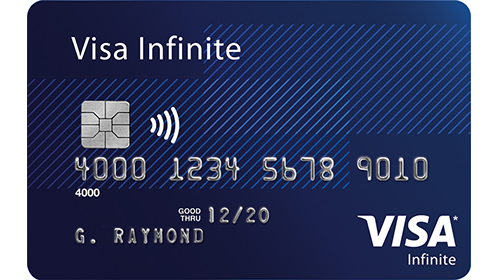

{
  "card_number": "4000 1234 5678 9010",
  "bank_name": "",
  "cobrand_partner": "",
  "cardholder_name": "G. RAYMOND",
  "validity": "12/20",
  "payment_network": "Visa"
}


In [6]:
answer = ask_qwen(prompt, img)
display(img)
print(json.dumps(parse_json_from_text(answer), indent=2))